In [ ]:
name = "dataset-new"
dataset_dir = "dataset"

# The splits to load
splits = ["val"]

# Load the dataset, using tags to mark the samples in each split
dataset = fo.Dataset(name)
for split in splits:
    dataset.add_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )

dataset.persistent = True
classes = dataset.default_classes

If the dataset already exists because it had been saved under the same name before, load the dataset from fiftyone's folder.

In [2]:
dataset = fo.load_dataset('dataset')
classes = dataset.default_classes

### Perform detections <a name="modeldetect"></a>

Now we can call the aggregate model to do detections on the images contained in the dataset. The actual detection happens at line 6 where `detect()` is called. This function currently does inference using the GPU via `onnxruntime-gpu`. All detections are saved to the `predictions` keyword of each sample. A sample is one image with potentially multiple detections.

> **_NOTE:_** If the dataset already existed beforehand (you used `load_dataset()`), the detections are likely already saved in the dataset and you can skip the next step.

In [33]:
# Do detections with model and save bounding boxes
with fo.ProgressBar() as pb:
    for sample in pb(dataset.view()):
        image = Image.open(sample.filepath)
        w, h = image.size
        pred = detect(sample.filepath, '../weights/yolo-final.onnx', '../weights/resnet-fold-7.onnx')

        detections = []
        for _, row in pred.iterrows():
            xmin, xmax = int(row['xmin']), int(row['xmax'])
            ymin, ymax = int(row['ymin']), int(row['ymax'])
            rel_box = [
                xmin / w, ymin / h, (xmax - xmin) / w, (ymax - ymin) / h
            ]
            detections.append(
                fo.Detection(label=classes[int(row['cls'])],
                             bounding_box=rel_box,
                             confidence=int(row['cls_conf'])))

        sample["predictions_model_optimized_relabeled"] = fo.Detections(detections=detections)
        sample.save()

 100% |█████████████████| 640/640 [8.9m elapsed, 0s remaining, 1.4 samples/s]      


### Evaluate detections against ground truth <a name="modeldetectionseval"></a>

Having saved the predictions, we can now evaluate them by cross-checking with the ground truth labels. If we specify an `eval_key`, true positives, false positives and false negatives will be saved under that key.

In [34]:
results = dataset.view().evaluate_detections(
    "predictions_model_optimized_relabeled",
    gt_field="ground_truth",
    eval_key="eval_model_optimized_relabeled",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 640/640 [2.9s elapsed, 0s remaining, 242.0 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 640/640 [2.8s elapsed, 0s remaining, 235.9 samples/s]      


### Calculate results and plot them <a name="modelshowresults"></a>

Now we have the performance of the model saved in the `results` variable and can extract various metrics from that. Here we print a simple report of all classes and their precision and recall values as well as the mAP with the metric employed by [COCO](https://cocodataset.org/#detection-eval). Next, a confusion matrix is plotted for each class (in our case only one). Finally, we can show the precision vs. recall curve for a specified threshold value.

In [5]:
from helpers import set_size
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
# Style the plots
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8})

The code for the LaTeX table of the classification report can be printed by first converting the results to a pandas DataFrame and then calling the `to_latex()` method of the DataFrame. This code can then be inserted into the LaTeX document.

In [14]:
results_df = pd.DataFrame(results.report()).transpose().round(3)

# Export DataFrame to LaTeX tabular environment
print(results_df.to_latex())
# YOLO original with Resnet original and relabeled dataset
print(results.mAP())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Healthy      &      0.665 &   0.554 &     0.604 &    766.0 \\
Stressed     &      0.639 &   0.502 &     0.562 &    494.0 \\
micro avg    &      0.655 &   0.533 &     0.588 &   1260.0 \\
macro avg    &      0.652 &   0.528 &     0.583 &   1260.0 \\
weighted avg &      0.655 &   0.533 &     0.588 &   1260.0 \\
\bottomrule
\end{tabular}

0.35812991936475147


In [8]:
results_df = pd.DataFrame(results.report()).transpose().round(3)

# Export DataFrame to LaTeX tabular environment
print(results_df.to_latex())
# YOLO optimized with Resnet optimized and relabeled dataset
print(results.mAP())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Healthy      &      0.711 &   0.555 &     0.623 &    766.0 \\
Stressed     &      0.570 &   0.623 &     0.596 &    494.0 \\
micro avg    &      0.644 &   0.582 &     0.611 &   1260.0 \\
macro avg    &      0.641 &   0.589 &     0.609 &   1260.0 \\
weighted avg &      0.656 &   0.582 &     0.612 &   1260.0 \\
\bottomrule
\end{tabular}

0.38379973332791195


Ignoring unsupported argument `thresholds` for the 'matplotlib' backend
Ignoring unsupported argument `thresholds` for the 'matplotlib' backend


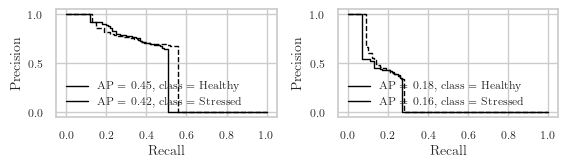

In [35]:
fig_save_dir = '../../thesis/graphics/'

fig, ax = plt.subplots(1, 2, figsize=set_size(width, subplots=(1,2)))
results.plot_pr_curves(classes=classes, iou_thresh=0.5, backend='matplotlib', ax=ax[0], color='black', linewidth=1)
results.plot_pr_curves(classes=classes, iou_thresh=0.95, backend='matplotlib', ax=ax[1], color='black', linewidth=1)
# Set the labels for the legends manually
ax[0].get_lines()[0].set_linestyle('dashed')
ax[1].get_lines()[0].set_linestyle('dashed')
#ax[0].legend(['AP: 0.46, Healthy', 'AP: 0.48, Stressed'], frameon=False)
#ax[1].legend(['AP: 0.16, Healthy', 'AP: 0.16, Stressed'], frameon=False)
fig.tight_layout()
fig.savefig(fig_save_dir + 'APmodel-model-optimized-relabeled.pdf', format='pdf', bbox_inches='tight')

The confusion matrix for the aggregate model seems to not show the cases where the object detection was successful but the class was wrong. For example, in the matrix below all classifications were correct or the detection failed. Under column _Stressed_ and row _Healthy_ not a single item is recorded. It seems that this evaluation metric does not have as much relevance when compared to the AP curves above or the mAP values.

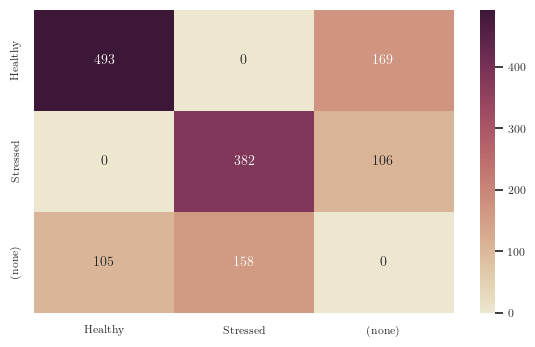

In [11]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=set_size(width, subplots=(1,1)))
# Manually set confusion matrix values obtained from results.plot_confusion_matrix()
matrix = np.array([[493, 0, 169], [0, 382, 106], [105, 158, 0]])
labels = ['Healthy', 'Stressed', '(none)']
sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True, start=.3, hue=1, light=.9))
fig.tight_layout()
fig.savefig(fig_save_dir + 'CMmodel-relabeled.pdf', format='pdf', bbox_inches='tight')

### View dataset in fiftyone <a name="modelfiftyonesession"></a>

We can launch a fiftyone session in a new tab to explore the dataset and the results.

In [21]:
session = fo.launch_app(dataset, auto=False)
session.view = dataset.view()
session.open_tab()

Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port
Session launched. Run `session.show()` to open the App in a cell output.


<IPython.core.display.Javascript object>

In [104]:
session.close()